<a href="https://colab.research.google.com/github/jahinhossain/PDFtoTEXT/blob/main/Main_Deep_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Importing the libraries

In [ ]:
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import shutil
import os
tf.__version__

'2.15.0'

In [ ]:
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.models import Sequential
import os
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import models, layers





In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Removing Duplicate from original Dataset


In [ ]:
source_folder = '/content/drive/MyDrive/Dataset'
destination_folder = '/content/drive/MyDrive/Destination_Tomato3'

In [ ]:
import os
import hashlib
from collections import defaultdict

# Function to generate the hash of a file
def file_hash(file_path):
    hasher = hashlib.md5()
    with open(file_path, 'rb') as f:
        # Read the file in chunks for memory efficiency
        for chunk in iter(lambda: f.read(4096), b""):
            hasher.update(chunk)
    return hasher.hexdigest()

# Function to find and remove duplicate images in a directory
def remove_duplicates(directory):
    # Dictionary to store file hashes
    hash_dict = defaultdict(list)

    # Iterate through files in the directory
    for root, dirs, files in os.walk(directory):
        for file in files:
            file_path = os.path.join(root, file)
            # Calculate the hash of the file
            hash_val = file_hash(file_path)
            # Add the file path to the dictionary based on its hash
            hash_dict[hash_val].append(file_path)

    # Remove duplicate images
    for hash_val, file_paths in hash_dict.items():
        if len(file_paths) > 1:  # If duplicates are found
            # Remove all duplicates except the first occurrence
            for file_path in file_paths[1:]:
                os.remove(file_path)
                print(f"Removed: {file_path}")

# Directory path containing images
directory_path = source_folder

# Remove duplicates in the directory
remove_duplicates(directory_path)


### Spliting data into 70% training, 10% validation, and 20% testing

In [ ]:

def create_data_splits(source_folder, destination_folder):
    # Create destination folders
    train_folder = os.path.join(destination_folder, 'train')
    val_folder = os.path.join(destination_folder, 'val')
    test_folder = os.path.join(destination_folder, 'test')

    os.makedirs(train_folder, exist_ok=True)
    os.makedirs(val_folder, exist_ok=True)
    os.makedirs(test_folder, exist_ok=True)

    # List all classes in the source folder
    classes = [d for d in os.listdir(source_folder) if os.path.isdir(os.path.join(source_folder, d))]

    for class_name in classes:
        class_source_folder = os.path.join(source_folder, class_name)
        class_train_folder = os.path.join(train_folder, class_name)
        class_val_folder = os.path.join(val_folder, class_name)
        class_test_folder = os.path.join(test_folder, class_name)

        os.makedirs(class_train_folder, exist_ok=True)
        os.makedirs(class_val_folder, exist_ok=True)
        os.makedirs(class_test_folder, exist_ok=True)

        # List all files in the class folder
        files = [f for f in os.listdir(class_source_folder) if os.path.isfile(os.path.join(class_source_folder, f))]

        # Split the data
        train_files, test_files = train_test_split(files, test_size=0.2, random_state=42)
        train_files, val_files = train_test_split(train_files, test_size=0.125, random_state=42)

        # Copy files to the respective folders
        for file in train_files:
            shutil.copy(os.path.join(class_source_folder, file), os.path.join(class_train_folder, file))

        for file in val_files:
            shutil.copy(os.path.join(class_source_folder, file), os.path.join(class_val_folder, file))

        for file in test_files:
            shutil.copy(os.path.join(class_source_folder, file), os.path.join(class_test_folder, file))

if __name__ == "__main__":
 create_data_splits(source_folder, destination_folder)


### Preprocessing Data

In [34]:
# Set the base directory
base_directory = destination_folder

# Set target size and batch size
target_size = (144, 144)
batch_size = 32

# Specify your data augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)
val_datagen = ImageDataGenerator(rescale=1/255.0,
                                shear_range=0.2,
                                zoom_range=0.2,
                                horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1/255.0,)

# Create data generators
training_set = train_datagen.flow_from_directory(
    directory=os.path.join(base_directory, 'train'),
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical',

)

validation_set = test_datagen.flow_from_directory(
    directory=os.path.join(base_directory, 'val'),
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical',

)

test_set = test_datagen.flow_from_directory(
    directory=os.path.join(base_directory, 'test'),
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False

)


Found 7591 images belonging to 10 classes.
Found 1088 images belonging to 10 classes.
Found 2174 images belonging to 10 classes.


In [ ]:
import os

# Path to the directory containing class folders
directory_path = '/content/drive/MyDrive/Destination_Tomato2/train'

# Get a list of class folders
class_folders = [os.path.join(directory_path, folder) for folder in os.listdir(directory_path) if os.path.isdir(os.path.join(directory_path, folder))]

# Calculate the minimum number of images among all classes
min_images = min([len(os.listdir(folder)) for folder in class_folders])

# Balance the number of images in each class
for folder in class_folders:
    images = os.listdir(folder)
    if len(images) > min_images:
        # Remove excess images
        images_to_remove = images[min_images:]
        for img in images_to_remove:
            os.remove(os.path.join(folder, img))
    elif len(images) < min_images:
        # Implement augmentation or copying existing images to balance
        # Example: Use image augmentation techniques or copy existing images
        pass

# Confirm the new count of images in each class
new_counts = {folder.split('/')[-1]: len(os.listdir(folder)) for folder in class_folders}
print("New counts of images in each class:", new_counts)


New counts of images in each class: {'Tomato___Tomato_Yellow_Leaf_Curl_Virus': 690, 'Tomato___Tomato_mosaic_virus': 690, 'Tomato___Target_Spot': 690, 'Tomato___Bacterial_spot': 690, 'Tomato___healthy': 690, 'Tomato___Leaf_Mold': 690, 'Tomato___Early_blight': 690, 'Tomato___Late_blight': 690, 'Tomato___Spider_mites Two-spotted_spider_mite': 690, 'Tomato___Septoria_leaf_spot': 690}


In [ ]:
import os

# Path to the directory containing class folders
directory_path = '/content/drive/MyDrive/Destination_Tomato2/val'

# Get a list of class folders
class_folders = [os.path.join(directory_path, folder) for folder in os.listdir(directory_path) if os.path.isdir(os.path.join(directory_path, folder))]

# Calculate the minimum number of images among all classes
min_images = min([len(os.listdir(folder)) for folder in class_folders])

# Balance the number of images in each class
for folder in class_folders:
    images = os.listdir(folder)
    if len(images) > min_images:
        # Remove excess images
        images_to_remove = images[min_images:]
        for img in images_to_remove:
            os.remove(os.path.join(folder, img))
    elif len(images) < min_images:
        # Implement augmentation or copying existing images to balance
        # Example: Use image augmentation techniques or copy existing images
        pass

# Confirm the new count of images in each class
new_counts = {folder.split('/')[-1]: len(os.listdir(folder)) for folder in class_folders}
print("New counts of images in each class:", new_counts)


New counts of images in each class: {'Tomato___Tomato_Yellow_Leaf_Curl_Virus': 99, 'Tomato___Tomato_mosaic_virus': 99, 'Tomato___Target_Spot': 99, 'Tomato___Bacterial_spot': 99, 'Tomato___healthy': 99, 'Tomato___Leaf_Mold': 99, 'Tomato___Early_blight': 99, 'Tomato___Late_blight': 99, 'Tomato___Spider_mites Two-spotted_spider_mite': 99, 'Tomato___Septoria_leaf_spot': 99}


In [ ]:
import os

# Path to the directory containing class folders
directory_path = '/content/drive/MyDrive/Destination_Tomato2/test'

# Get a list of class folders
class_folders = [os.path.join(directory_path, folder) for folder in os.listdir(directory_path) if os.path.isdir(os.path.join(directory_path, folder))]

# Calculate the minimum number of images among all classes
min_images = min([len(os.listdir(folder)) for folder in class_folders])

# Balance the number of images in each class
for folder in class_folders:
    images = os.listdir(folder)
    if len(images) > min_images:
        # Remove excess images
        images_to_remove = images[min_images:]
        for img in images_to_remove:
            os.remove(os.path.join(folder, img))
    elif len(images) < min_images:
        # Implement augmentation or copying existing images to balance
        # Example: Use image augmentation techniques or copy existing images
        pass

# Confirm the new count of images in each class
new_counts = {folder.split('/')[-1]: len(os.listdir(folder)) for folder in class_folders}
print("New counts of images in each class:", new_counts)


New counts of images in each class: {'Tomato___Tomato_Yellow_Leaf_Curl_Virus': 198, 'Tomato___Tomato_mosaic_virus': 198, 'Tomato___Target_Spot': 198, 'Tomato___Bacterial_spot': 198, 'Tomato___healthy': 198, 'Tomato___Leaf_Mold': 198, 'Tomato___Early_blight': 198, 'Tomato___Late_blight': 198, 'Tomato___Spider_mites Two-spotted_spider_mite': 198, 'Tomato___Septoria_leaf_spot': 198}


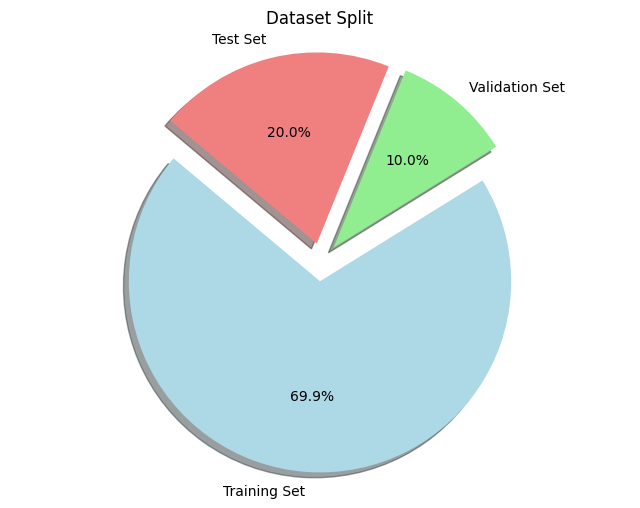

In [ ]:
import matplotlib.pyplot as plt

# Get the number of samples in each set
train_samples = len(training_set.filenames)
val_samples = len(validation_set.filenames)
test_samples = len(test_set.filenames)

# Calculate the percentages
total_samples = train_samples + val_samples + test_samples
train_percent = (train_samples / total_samples) * 100
val_percent = (val_samples / total_samples) * 100
test_percent = (test_samples / total_samples) * 100

# Create labels and sizes for the pie chart
labels = ['Training Set', 'Validation Set', 'Test Set']
sizes = [train_percent, val_percent, test_percent]
colors = ['lightblue', 'lightgreen', 'lightcoral']
explode = (0.1, 0.1, 0.1)  # explode all three slices

# Plotting the pie chart with exploded slices
plt.figure(figsize=(8, 6))
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('Dataset Split')
plt.show()


In [ ]:

# Get the counts of images per class in the training set
training_class_counts = training_set.classes
training_class_count = {class_name: training_class_counts.tolist().count(idx) for class_name, idx in training_set.class_indices.items()}

# Get the counts of images per class in the validation set
validation_class_counts = validation_set.classes
validation_class_count = {class_name: validation_class_counts.tolist().count(idx) for class_name, idx in validation_set.class_indices.items()}

# Get the counts of images per class in the test set
test_class_counts = test_set.classes
test_class_count = {class_name: test_class_counts.tolist().count(idx) for class_name, idx in test_set.class_indices.items()}

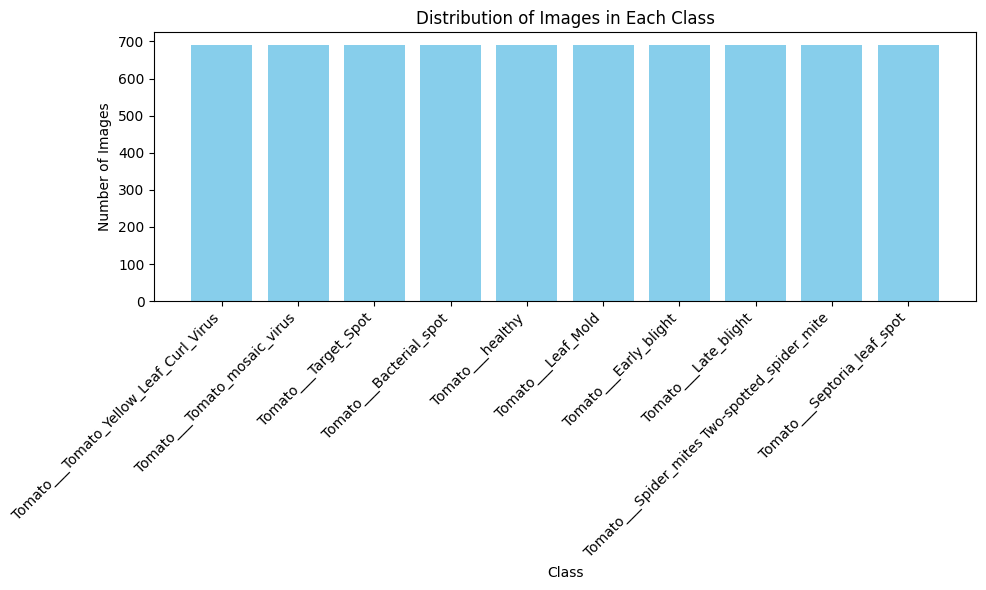

In [ ]:
import os
import matplotlib.pyplot as plt

# Path to the directory containing class folders
directory_path = '/content/drive/MyDrive/Destination_Tomato2/train'

# Get a list of class folders and count images in each folder
class_folders = [os.path.join(directory_path, folder) for folder in os.listdir(directory_path) if os.path.isdir(os.path.join(directory_path, folder))]
class_names = [folder.split('/')[-1] for folder in class_folders]
image_counts = [len(os.listdir(folder)) for folder in class_folders]

# Plotting the distribution
plt.figure(figsize=(10, 6))
plt.bar(class_names, image_counts, color='skyblue')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.title('Distribution of Images in Each Class')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


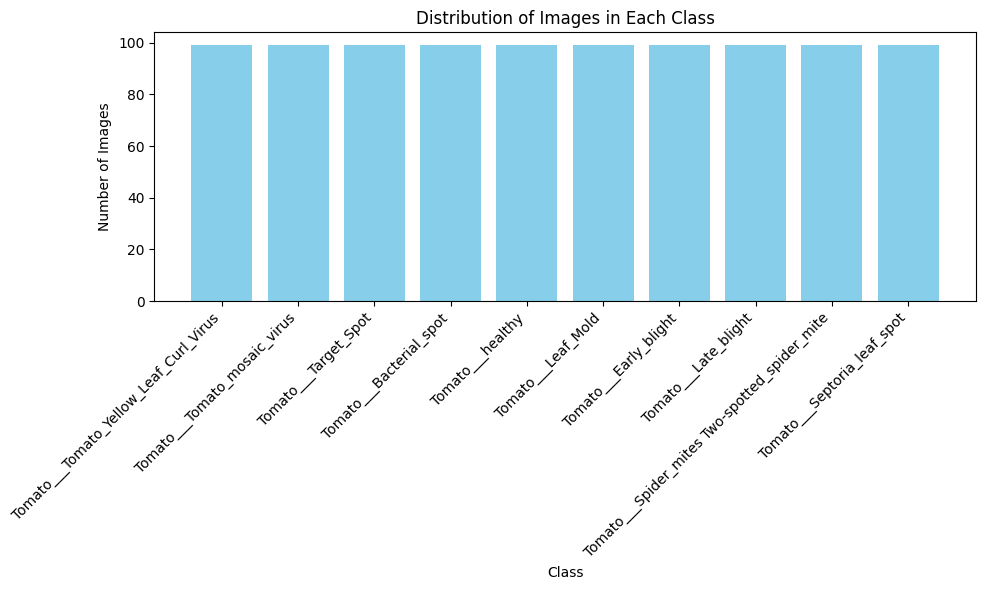

In [ ]:
import os
import matplotlib.pyplot as plt

# Path to the directory containing class folders
directory_path = '/content/drive/MyDrive/Destination_Tomato2/val'

# Get a list of class folders and count images in each folder
class_folders = [os.path.join(directory_path, folder) for folder in os.listdir(directory_path) if os.path.isdir(os.path.join(directory_path, folder))]
class_names = [folder.split('/')[-1] for folder in class_folders]
image_counts = [len(os.listdir(folder)) for folder in class_folders]

# Plotting the distribution
plt.figure(figsize=(10, 6))
plt.bar(class_names, image_counts, color='skyblue')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.title('Distribution of Images in Each Class')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


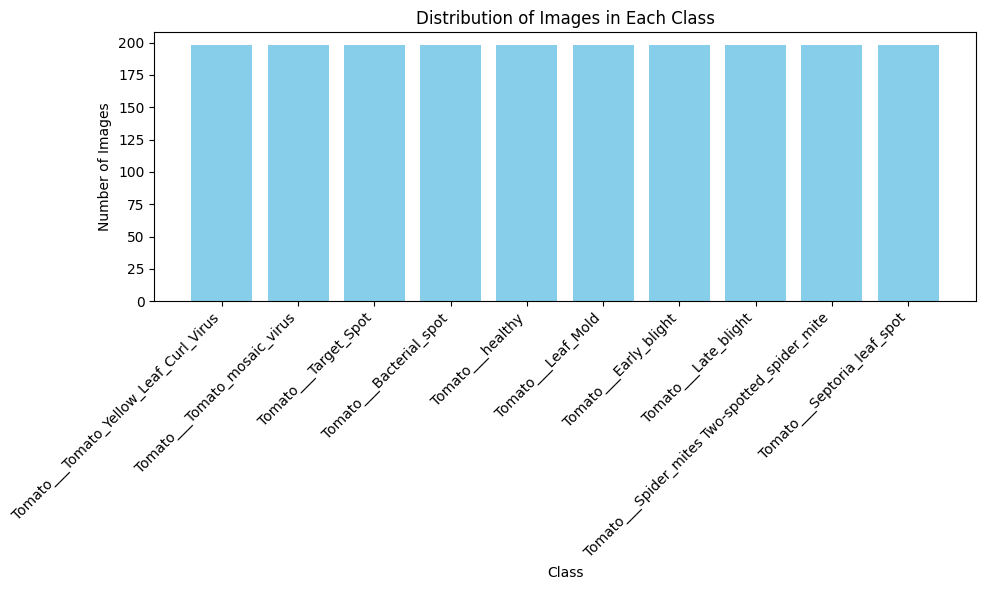

In [ ]:
import os
import matplotlib.pyplot as plt

# Path to the directory containing class folders
directory_path = '/content/drive/MyDrive/Destination_Tomato2/test'

# Get a list of class folders and count images in each folder
class_folders = [os.path.join(directory_path, folder) for folder in os.listdir(directory_path) if os.path.isdir(os.path.join(directory_path, folder))]
class_names = [folder.split('/')[-1] for folder in class_folders]
image_counts = [len(os.listdir(folder)) for folder in class_folders]

# Plotting the distribution
plt.figure(figsize=(10, 6))
plt.bar(class_names, image_counts, color='skyblue')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.title('Distribution of Images in Each Class')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


### Buidling the CNN

In [ ]:

model2 = models.Sequential([
    layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(144, 144, 3), padding='same'),
    layers.MaxPooling2D(pool_size=(2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5),

    # Output layer
    layers.Dense(10, activation='softmax')
])


In [ ]:
model2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 144, 144, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 72, 72, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 70, 70, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 35, 35, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 33, 33, 64)        36928     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 16, 16, 64)        0

In [ ]:

model1 = models.Sequential([
    layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(144, 144, 3), padding='same'),
    layers.MaxPooling2D(pool_size=(2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),


    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),



    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5),

    # Output layer
    layers.Dense(10, activation='softmax')
])


In [ ]:
model1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 144, 144, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 72, 72, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 70, 70, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 35, 35, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 33, 33, 64)        36928     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 16, 16, 64)       

### Compiling the CNN

In [35]:
optimizer = Adam(learning_rate=0.001)


In [ ]:
model2.compile(optimizer =optimizer, loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [36]:
model1.compile(optimizer =optimizer, loss = 'categorical_crossentropy', metrics = ['accuracy'])

**Early stopping**

In [37]:
early_stopping = EarlyStopping(monitor='val_accuracy',
                   mode='max',
                   patience=10,
                   restore_best_weights=True)


### Training the CNN on the Training set and evaluating it on the Test set

In [ ]:
history2=model2.fit(x=training_set, validation_data=validation_set, epochs=25, callbacks=[early_stopping])

Epoch 1/25
238/238 [==============================] - 2678s 11s/step - loss: 2.0573 - accuracy: 0.2351 - val_loss: 1.3756 - val_accuracy: 0.5781
Epoch 2/25
238/238 [==============================] - 62s 260ms/step - loss: 1.5492 - accuracy: 0.4438 - val_loss: 1.3363 - val_accuracy: 0.5046
Epoch 3/25
238/238 [==============================] - 62s 261ms/step - loss: 1.3285 - accuracy: 0.5215 - val_loss: 0.9564 - val_accuracy: 0.6746
Epoch 4/25
238/238 [==============================] - 65s 272ms/step - loss: 1.2148 - accuracy: 0.5575 - val_loss: 1.0771 - val_accuracy: 0.6351
Epoch 5/25
238/238 [==============================] - 66s 277ms/step - loss: 1.1220 - accuracy: 0.5944 - val_loss: 1.0740 - val_accuracy: 0.6085
Epoch 6/25
238/238 [==============================] - 62s 262ms/step - loss: 1.0173 - accuracy: 0.6213 - val_loss: 1.1121 - val_accuracy: 0.6186
Epoch 7/25
238/238 [==============================] - 63s 264ms/step - loss: 1.0196 - accuracy: 0.6351 - val_loss: 0.7429 - val_ac

In [38]:
history1=model1.fit(x=training_set, validation_data=validation_set, epochs=25, callbacks=[early_stopping])

Epoch 1/25
238/238 [==============================] - 65s 264ms/step - loss: 2.2001 - accuracy: 0.1647 - val_loss: 1.8891 - val_accuracy: 0.3061
Epoch 2/25
238/238 [==============================] - 67s 280ms/step - loss: 1.7842 - accuracy: 0.3612 - val_loss: 1.5566 - val_accuracy: 0.4090
Epoch 3/25
238/238 [==============================] - 63s 265ms/step - loss: 1.4493 - accuracy: 0.4706 - val_loss: 1.2225 - val_accuracy: 0.5588
Epoch 4/25
238/238 [==============================] - 63s 264ms/step - loss: 1.1975 - accuracy: 0.5622 - val_loss: 1.0784 - val_accuracy: 0.5772
Epoch 5/25
238/238 [==============================] - 65s 274ms/step - loss: 1.0167 - accuracy: 0.6383 - val_loss: 0.8462 - val_accuracy: 0.6719
Epoch 6/25
238/238 [==============================] - 62s 262ms/step - loss: 0.8884 - accuracy: 0.6882 - val_loss: 0.8298 - val_accuracy: 0.6893
Epoch 7/25
238/238 [==============================] - 64s 267ms/step - loss: 0.7425 - accuracy: 0.7435 - val_loss: 0.5997 - val_ac

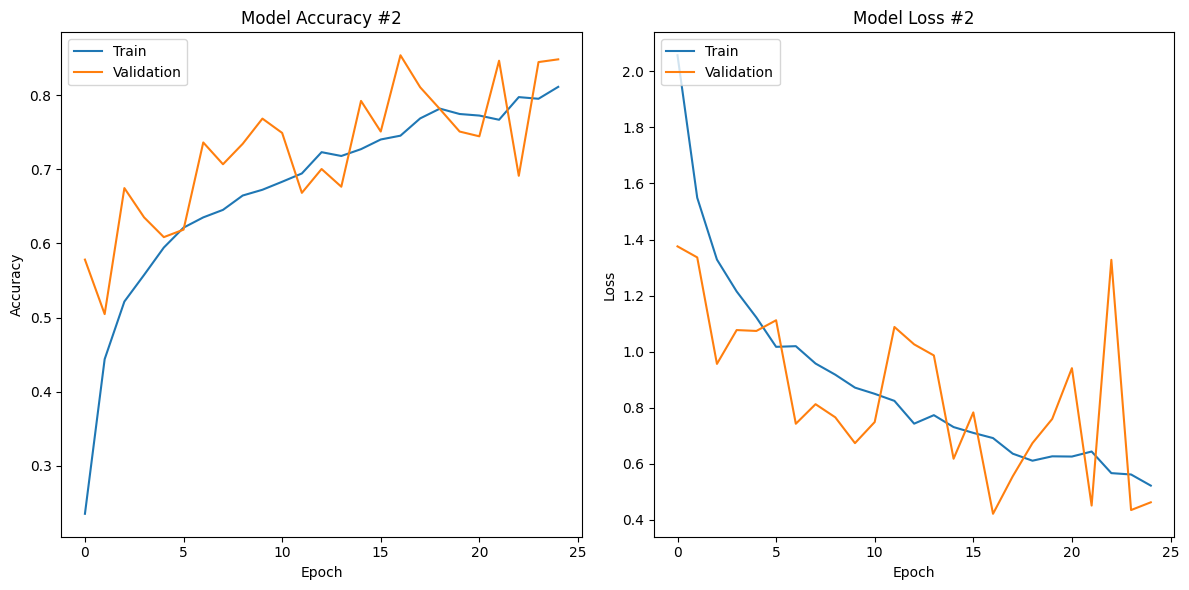

In [ ]:
plt.figure(figsize=(12, 6))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('Model Accuracy #2')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('Model Loss #2')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

# Improve layout
plt.tight_layout()

# Show plot
plt.show()

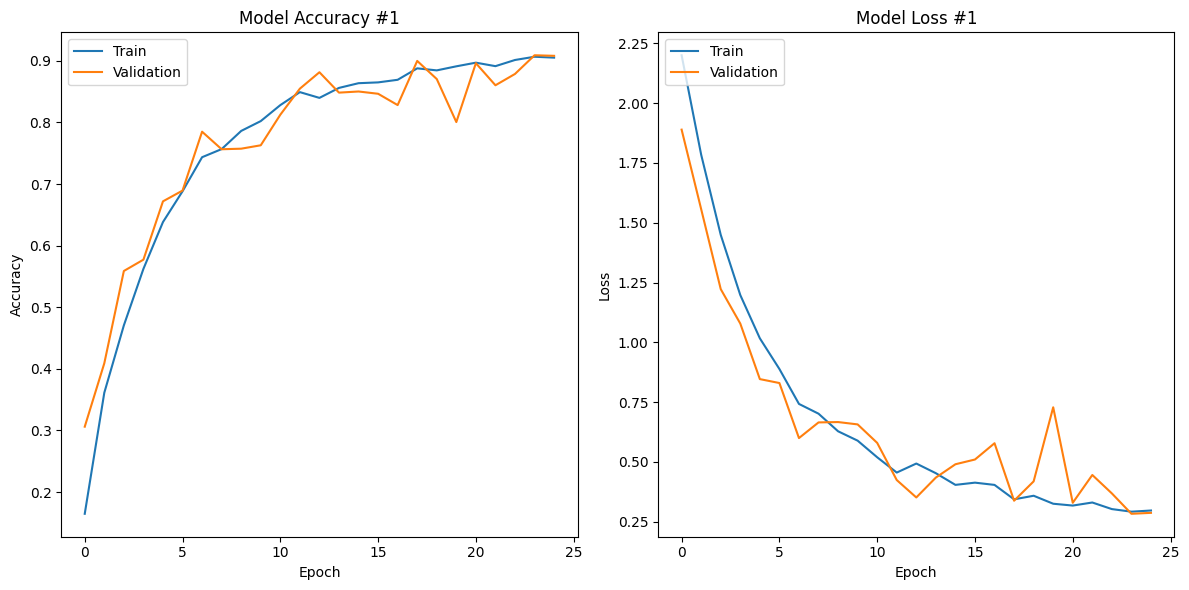

In [39]:
plt.figure(figsize=(12, 6))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history1.history['accuracy'])
plt.plot(history1.history['val_accuracy'])
plt.title('Model Accuracy #1')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.title('Model Loss #1')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

# Improve layout
plt.tight_layout()

# Show plot
plt.show()

68/68 [==============================] - 5s 78ms/step


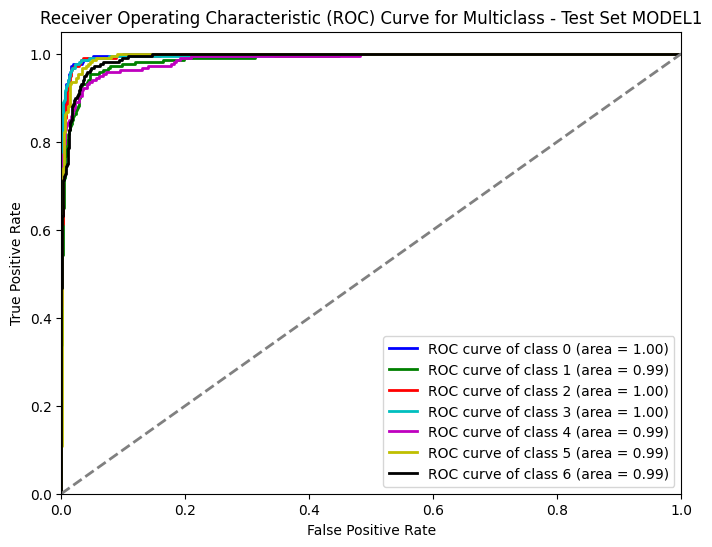

In [40]:
from sklearn.metrics import roc_curve, auc
import numpy as np

# Get predictions for the test set
y_pred_probabilities = model1.predict(test_set)

# Obtain true labels for the test set
y_true = []
for i in range(len(test_set)):
    y_true.extend(np.argmax(test_set[i][1], axis=1))

# Flatten the predictions
y_pred = np.argmax(y_pred_probabilities, axis=1)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = len(test_set.class_indices)

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve((np.array(y_true) == i).astype(int), y_pred_probabilities[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for each class
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']  # Add more colors if needed
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for Multiclass - Test Set MODEL1')
plt.legend(loc="lower right")
plt.show()


In [ ]:
from sklearn.metrics import roc_curve, auc
import numpy as np

# Get predictions for the test set
y_pred_probabilities = model2.predict(test_set)

# Obtain true labels for the test set
y_true = []
for i in range(len(test_set)):
    y_true.extend(np.argmax(test_set[i][1], axis=1))

# Flatten the predictions
y_pred = np.argmax(y_pred_probabilities, axis=1)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = len(test_set.class_indices)

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve((np.array(y_true) == i).astype(int), y_pred_probabilities[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for each class
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']  # Add more colors if needed
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for Multiclass - Test Set MODEL2')
plt.legend(loc="lower right")
plt.show()


116/116 [==============================] - 11s 95ms/step


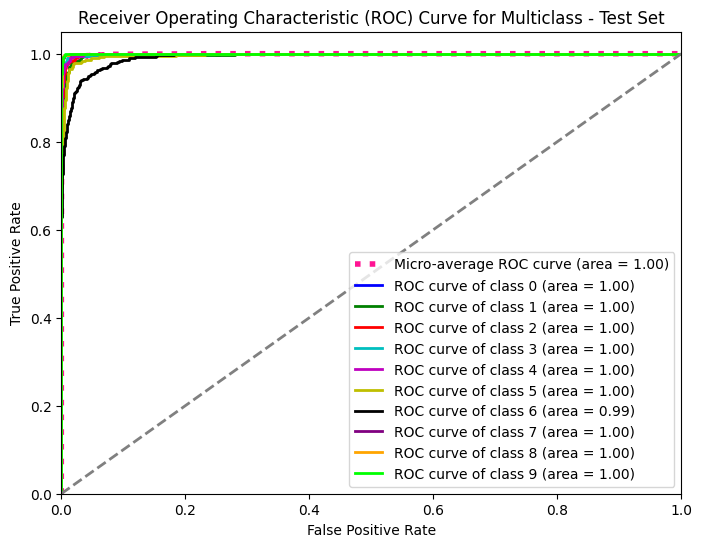

In [ ]:
from sklearn.metrics import roc_curve, auc
import numpy as np
import matplotlib.pyplot as plt

# Get predictions for the test set
y_pred_probabilities = model1.predict(test_set)

# Obtain true labels for the test set
y_true = []
for i in range(len(test_set)):
    y_true.extend(np.argmax(test_set[i][1], axis=1))

# Flatten the predictions
y_pred = np.argmax(y_pred_probabilities, axis=1)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = len(test_set.class_indices)

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve((np.array(y_true) == i).astype(int), y_pred_probabilities[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr_micro, tpr_micro, _ = roc_curve(label_binarize(y_true, classes=range(n_classes)).ravel(), y_pred_probabilities.ravel())
roc_auc_micro = auc(fpr_micro, tpr_micro)

# Plot ROC curve for micro-average
plt.figure(figsize=(8, 6))
plt.plot(fpr_micro, tpr_micro, label='Micro-average ROC curve (area = {0:0.2f})'.format(roc_auc_micro), color='deeppink', linestyle=':', linewidth=4)

# Plot ROC curve for each class
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'purple', 'orange', 'lime']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for Multiclass - Test Set')
plt.legend(loc="lower right")
plt.show()


In [41]:
# Evaluate the model on the test set
evaluation = model1.evaluate(test_set)

# Extracting metrics names and values
metrics_names = model1.metrics_names
metrics_values = evaluation

# Displaying the performance metrics
for name, value in zip(metrics_names, metrics_values):
    print(f'{name}: {value}')

68/68 [==============================] - 5s 78ms/step - loss: 0.2877 - accuracy: 0.9066
loss: 0.28766030073165894
accuracy: 0.9066237211227417


In [ ]:
# Evaluate the model on the test set
evaluation = model2.evaluate(test_set)

# Extracting metrics names and values
metrics_names = model2.metrics_names
metrics_values = evaluation

# Displaying the performance metrics
for name, value in zip(metrics_names, metrics_values):
    print(f'{name}: {value}')

68/68 [==============================] - 705s 11s/step - loss: 0.4688 - accuracy: 0.8468
loss: 0.46883735060691833
accuracy: 0.8468261361122131


68/68 [==============================] - 6s 80ms/step
Overall Accuracy: 0.85
Overall Precision: 0.86
Overall F1 Score: 0.85


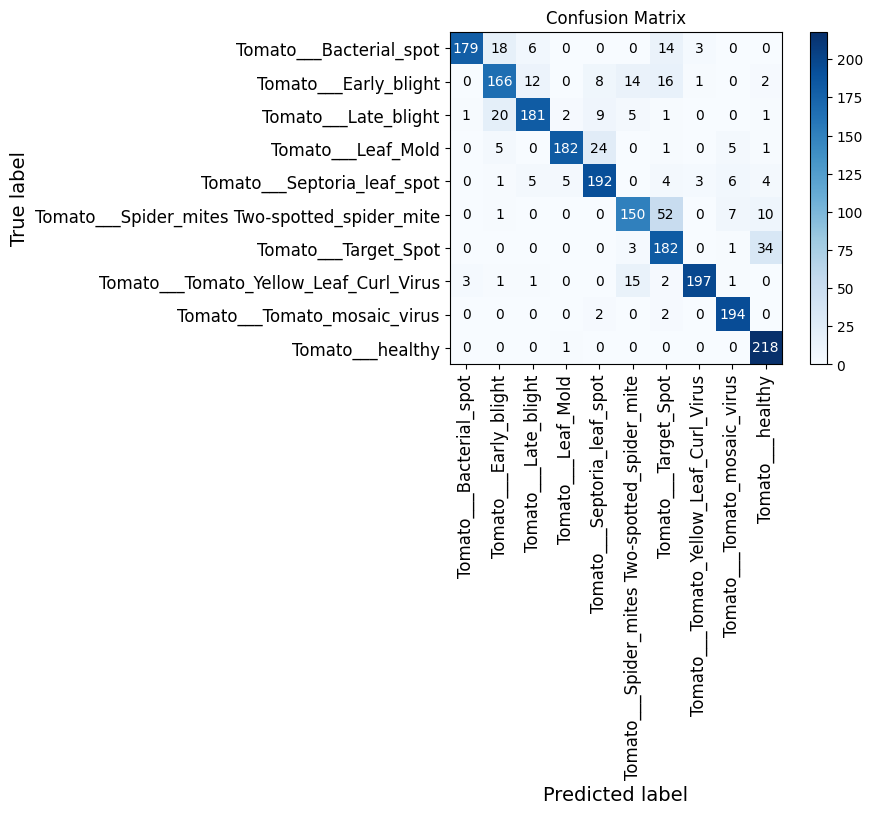

In [ ]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

# Get true labels and predictions for the test set
y_true = test_set.classes
y_pred = np.argmax(model2.predict(test_set), axis=1)

# Generate confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Display overall accuracy, precision, and F1 score
report = classification_report(y_true, y_pred, output_dict=True)
overall_accuracy = report['accuracy']
overall_precision = report['weighted avg']['precision']
overall_f1_score = report['weighted avg']['f1-score']

print(f"Overall Accuracy: {overall_accuracy:.2f}")
print(f"Overall Precision: {overall_precision:.2f}")
print(f"Overall F1 Score: {overall_f1_score:.2f}")

# Set the figure size
plt.figure(figsize=(10, 8))

# Display the confusion matrix
plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()

# Label the axes
classes = list(test_set.class_indices.keys())
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=90, fontsize=12)
plt.yticks(tick_marks, classes, fontsize=12)

# Display the numbers in each cell with better contrast
thresh = cm.max() / 2.
for i in range(len(classes)):
    for j in range(len(classes)):
        plt.text(j, i, f"{cm[i, j]:.0f}", ha="center", va="center",
                 color="white" if cm[i, j] > thresh else "black",
                 fontsize=10)

# Improve layout
plt.tight_layout()

# Label the axes more explicitly
plt.ylabel("True label", fontsize=14)
plt.xlabel("Predicted label", fontsize=14)

# Show plot
plt.show()

In [ ]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

# Get true labels and predictions for the test set
y_true = test_set.classes1.predict(test_set), axis=1)

# Generate confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Display overall accuracy, precision, and F1 score
report = classification_report(y_true, y_pred, output_dict=True)
overall_accuracy = report['accuracy']
overall_precision = report['weighted avg']['precision']
overall_f1_score = report['weighted avg']['f1-score']

print(f"Overall Accuracy: {overall_accuracy:.2f}")
print(f"Overall Precision: {overall_precision:.2f}")
print(f"Overall F1 Score: {overall_f1_score:.2f}")

# Set the figure size
plt.figure(figsize=(10, 8))

# Display the confusion matrix
plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()

# Label the axes
classes = list(test_set.class_indices.keys())
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=90, fontsize=12)
plt.yticks(tick_marks, classes, fontsize=12)

# Display the numbers in each cell with better contrast
thresh = cm.max() / 2.
for i in range(len(classes)):
    for j in range(len(classes)):
        plt.text(j, i, f"{cm[i, j]:.0f}", ha="center", va="center",
                 color="white" if cm[i, j] > thresh else "black",
                 fontsize=10)

# Improve layout
plt.tight_layout()

# Label the axes more explicitly
plt.ylabel("True label", fontsize=14)
plt.xlabel("Predicted label", fontsize=14)

# Show plot
plt.show()

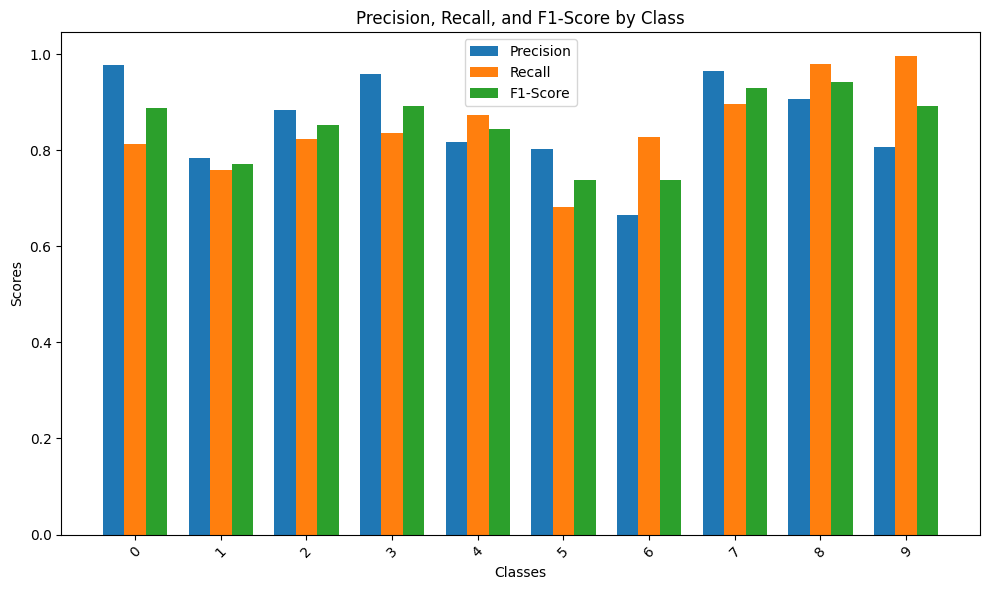

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report

# Assuming 'y_true' and 'y_pred' are defined as in your previous code
# Generate classification report
report = classification_report(y_true, y_pred, output_dict=True)

# Extract precision, recall, and F1-score for each class
classes = list(report.keys())[:-3]  # Extract class labels
precision = [report[label]['precision'] for label in classes]
recall = [report[label]['recall'] for label in classes]
f1_score = [report[label]['f1-score'] for label in classes]

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))

bar_width = 0.25
index = np.arange(len(classes))

bar1 = ax.bar(index, precision, bar_width, label='Precision')
bar2 = ax.bar(index + bar_width, recall, bar_width, label='Recall')
bar3 = ax.bar(index + 2 * bar_width, f1_score, bar_width, label='F1-Score')

ax.set_xlabel('Classes')
ax.set_ylabel('Scores')
ax.set_title('Precision, Recall, and F1-Score by Class')
ax.set_xticks(index + bar_width)
ax.set_xticklabels(classes, rotation=45)
ax.legend()

plt.tight_layout()
plt.show()


116/116 [==============================] - 573s 5s/step
Overall Accuracy: 0.94
Overall Precision: 0.94
Overall F1 Score: 0.94


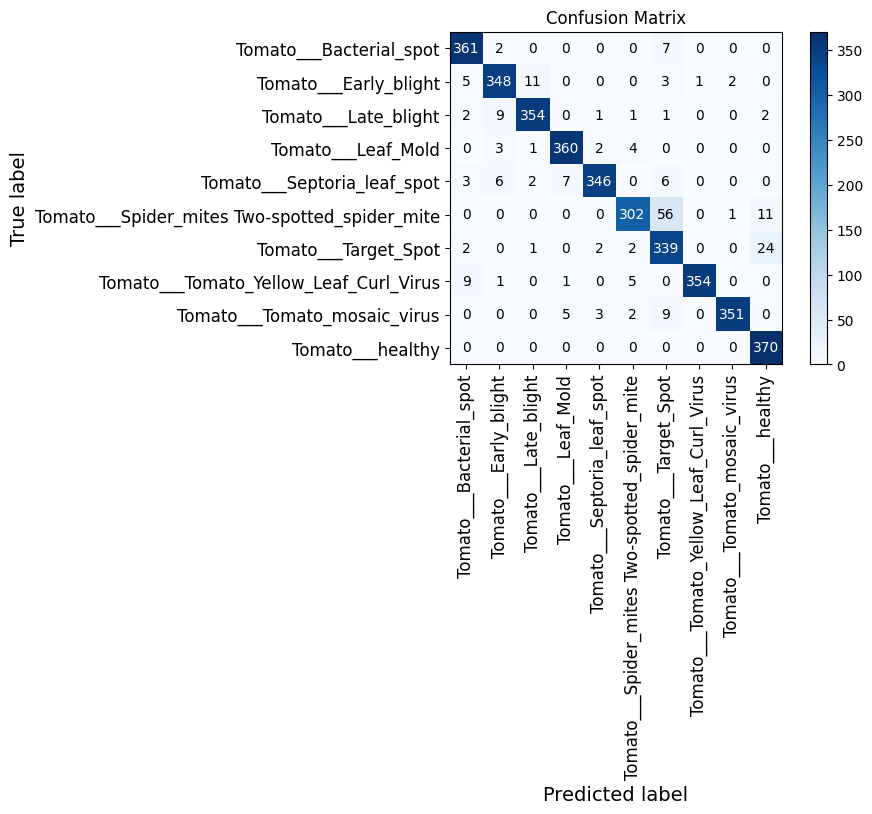

In [ ]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

# Get true labels and predictions for the test set
y_true = test_set.classes
y_pred = np.argmax(model1.predict(test_set), axis=1)

# Generate confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Display overall accuracy, precision, and F1 score
report = classification_report(y_true, y_pred, output_dict=True)
overall_accuracy = report['accuracy']
overall_precision = report['weighted avg']['precision']
overall_f1_score = report['weighted avg']['f1-score']

print(f"Overall Accuracy: {overall_accuracy:.2f}")
print(f"Overall Precision: {overall_precision:.2f}")
print(f"Overall F1 Score: {overall_f1_score:.2f}")

# Set the figure size
plt.figure(figsize=(10, 8))

# Display the confusion matrix
plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()

# Label the axes
classes = list(test_set.class_indices.keys())
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=90, fontsize=12)
plt.yticks(tick_marks, classes, fontsize=12)

# Display the numbers in each cell with better contrast
thresh = cm.max() / 2.
for i in range(len(classes)):
    for j in range(len(classes)):
        plt.text(j, i, f"{cm[i, j]:.0f}", ha="center", va="center",
                 color="white" if cm[i, j] > thresh else "black",
                 fontsize=10)

# Improve layout
plt.tight_layout()

# Label the axes more explicitly
plt.ylabel("True label", fontsize=14)
plt.xlabel("Predicted label", fontsize=14)

# Show plot
plt.show()

68/68 [==============================] - 8s 112ms/step
Overall Accuracy: 0.91
Overall Precision: 0.91
Overall F1 Score: 0.91


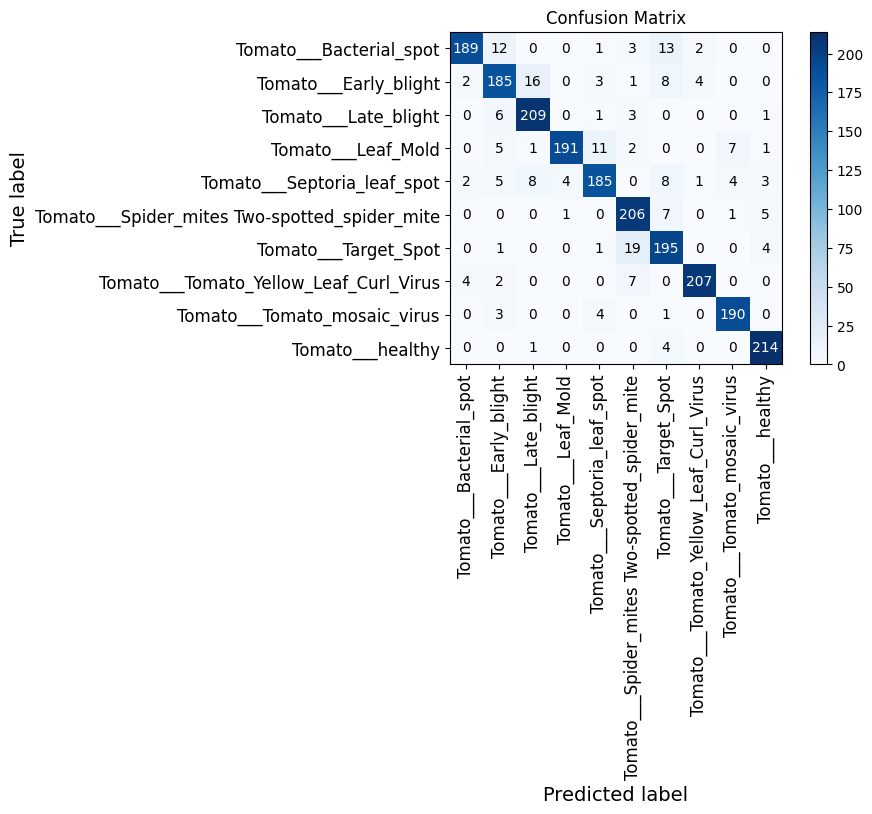

In [42]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

# Get true labels and predictions for the test set
y_true = test_set.classes
y_pred = np.argmax(model1.predict(test_set), axis=1)

# Generate confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Display overall accuracy, precision, and F1 score
report = classification_report(y_true, y_pred, output_dict=True)
overall_accuracy = report['accuracy']
overall_precision = report['weighted avg']['precision']
overall_f1_score = report['weighted avg']['f1-score']

print(f"Overall Accuracy: {overall_accuracy:.2f}")
print(f"Overall Precision: {overall_precision:.2f}")
print(f"Overall F1 Score: {overall_f1_score:.2f}")

# Set the figure size
plt.figure(figsize=(10, 8))

# Display the confusion matrix
plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()

# Label the axes
classes = list(test_set.class_indices.keys())
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=90, fontsize=12)
plt.yticks(tick_marks, classes, fontsize=12)

# Display the numbers in each cell with better contrast
thresh = cm.max() / 2.
for i in range(len(classes)):
    for j in range(len(classes)):
        plt.text(j, i, f"{cm[i, j]:.0f}", ha="center", va="center",
                 color="white" if cm[i, j] > thresh else "black",
                 fontsize=10)

# Improve layout
plt.tight_layout()

# Label the axes more explicitly
plt.ylabel("True label", fontsize=14)
plt.xlabel("Predicted label", fontsize=14)

# Show plot
plt.show()

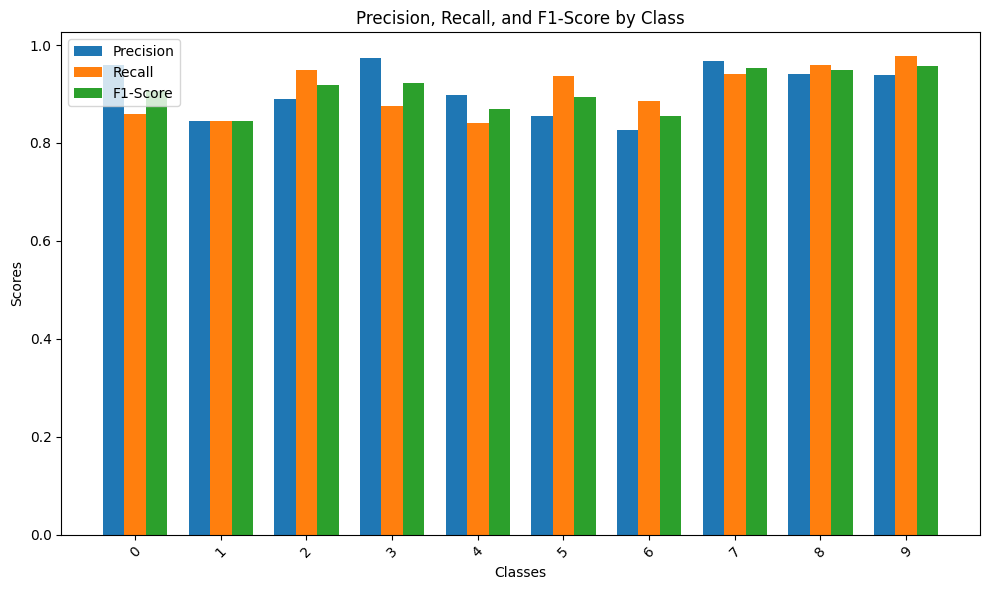

In [43]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report

# Assuming 'y_true' and 'y_pred' are defined as in your previous code
# Generate classification report
report = classification_report(y_true, y_pred, output_dict=True)

# Extract precision, recall, and F1-score for each class
classes = list(report.keys())[:-3]  # Extract class labels
precision = [report[label]['precision'] for label in classes]
recall = [report[label]['recall'] for label in classes]
f1_score = [report[label]['f1-score'] for label in classes]

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))

bar_width = 0.25
index = np.arange(len(classes))

bar1 = ax.bar(index, precision, bar_width, label='Precision')
bar2 = ax.bar(index + bar_width, recall, bar_width, label='Recall')
bar3 = ax.bar(index + 2 * bar_width, f1_score, bar_width, label='F1-Score')

ax.set_xlabel('Classes')
ax.set_ylabel('Scores')
ax.set_title('Precision, Recall, and F1-Score by Class')
ax.set_xticks(index + bar_width)
ax.set_xticklabels(classes, rotation=45)
ax.legend()

plt.tight_layout()
plt.show()


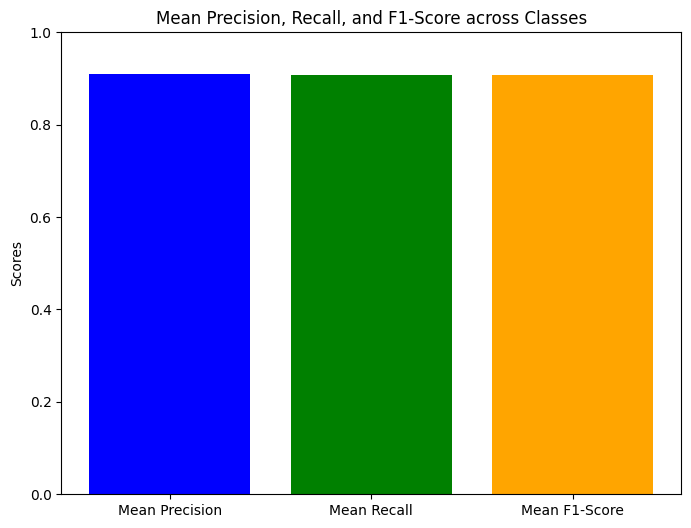

In [44]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report

# Assuming 'y_true' and 'y_pred' are defined as in your previous code
# Generate classification report
report = classification_report(y_true, y_pred, output_dict=True)

# Extract precision, recall, and F1-score for each class
classes = list(report.keys())[:-3]  # Extract class labels
precision = [report[label]['precision'] for label in classes]
recall = [report[label]['recall'] for label in classes]
f1_score = [report[label]['f1-score'] for label in classes]

# Calculate the mean precision, recall, and F1-score across all classes
mean_precision = np.mean(precision)
mean_recall = np.mean(recall)
mean_f1_score = np.mean(f1_score)

# Plotting the mean scores
labels = ['Mean Precision', 'Mean Recall', 'Mean F1-Score']
scores = [mean_precision, mean_recall, mean_f1_score]

plt.figure(figsize=(8, 6))
plt.bar(labels, scores, color=['blue', 'green', 'orange'])
plt.ylabel('Scores')
plt.title('Mean Precision, Recall, and F1-Score across Classes')
plt.ylim(0, 1)  # Set the y-axis limit for better visualization
plt.show()
